## Moving Average Convergence and Divergence(MACD)

In [84]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import backtrader as bt
import matplotlib 

In [85]:
class MACD(bt.Strategy):
    params = (
        ('macdfast', 12),
        ('macdslow', 26),
        ('signalline', 9)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close

        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.macd = bt.indicators.MACD(
            self.data, period_me1=self.params.macdfast, period_me2=self.params.macdslow, period_signal = self.params.signalline)
        self.cross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.cross > 0:
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                self.order = self.buy()
            elif self.cross < 0:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.order = self.sell()
        else:
            if self.getposition(data=self.data).size > 0 and self.cross < 0:
                self.log('Long ended, %.2f' % self.data.close[0])
                self.order = self.close()
            elif self.getposition(data=self.data).size<0 and self.cross > 0:
                self.log('Short ended, %.2f' % self.data.close[0])  
                self.order = self.close()

In [86]:
#Instantiate Cerebro engine
cerebro = bt.Cerebro()

In [87]:
#Add data feed to Cerebro
data = bt.feeds.YahooFinanceCSVData(
    dataname='data/BAJFINANCE.NS.csv',
    fromdate=datetime.datetime(2018, 1,1),
    todate=datetime.datetime(2019, 12, 31))
cerebro.adddata(data)

In [88]:
#Add strategy to Cerebro
cerebro.addstrategy(MACD)


0

In [89]:
# Set our desired cash start
cerebro.broker.setcash(100000.0)
# Set the commission
cerebro.broker.setcommission(commission=0.01)

In [90]:
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00


In [91]:
#Run Cerebro Engine
cerebro.run()

2018-04-20, SELL CREATE, 1869.59
2018-04-23, SELL EXECUTED, Price: 1869.19, Cost: -1869.19, Comm 18.69
2018-05-17, Short ended, 2054.62
2018-05-18, BUY EXECUTED, Price: 2058.00, Cost: -1869.19, Comm 20.58
2018-05-18, OPERATION PROFIT, GROSS -188.81, NET -228.08
2018-06-04, SELL CREATE, 2050.99
2018-06-05, SELL EXECUTED, Price: 2053.13, Cost: -2053.13, Comm 20.53
2018-06-07, Short ended, 2156.98
2018-06-08, BUY EXECUTED, Price: 2152.46, Cost: -2053.13, Comm 21.52
2018-06-08, OPERATION PROFIT, GROSS -99.33, NET -141.39
2018-06-21, SELL CREATE, 2244.48
2018-06-22, SELL EXECUTED, Price: 2253.97, Cost: -2253.97, Comm 22.54
2018-06-22, Short ended, 2322.62
2018-06-25, BUY EXECUTED, Price: 2328.54, Cost: -2253.97, Comm 23.29
2018-06-25, OPERATION PROFIT, GROSS -74.57, NET -120.40
2018-06-28, SELL CREATE, 2261.63
2018-06-29, SELL EXECUTED, Price: 2268.98, Cost: -2268.98, Comm 22.69
2018-07-13, Short ended, 2458.63
2018-07-16, BUY EXECUTED, Price: 2465.00, Cost: -2268.98, Comm 24.65
2018-07-16,

In [92]:
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Final Portfolio Value: 97251.63


<IPython.core.display.Javascript object>


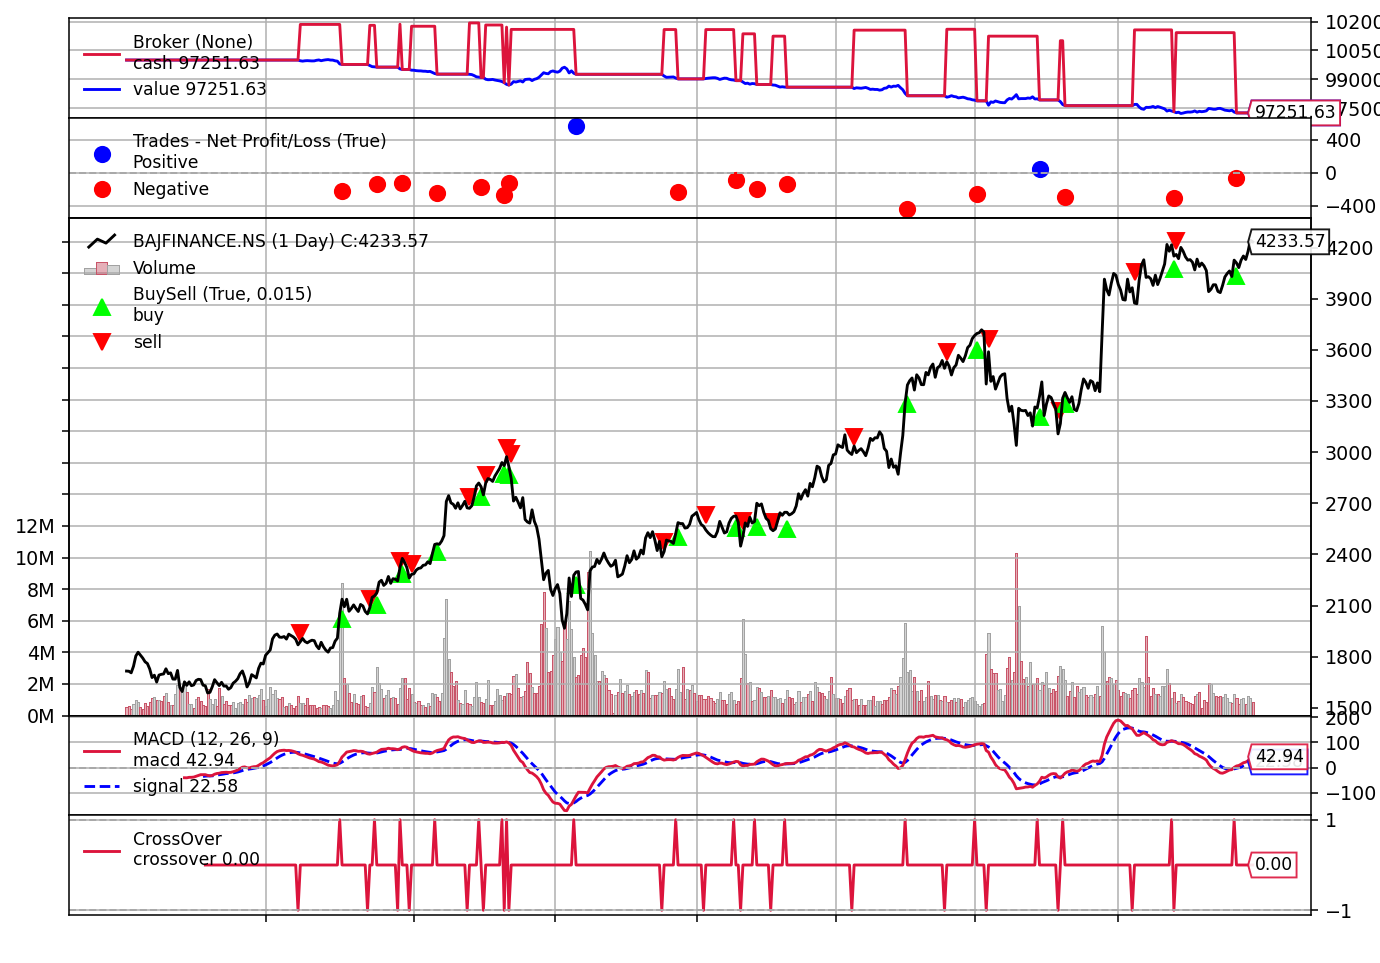

[[<Figure size 640x480 with 6 Axes>]]

In [93]:
cerebro.plot()